# Face Recognition (Research Project)

Recognising Faces of famous Celebrities

### Data Used
VGG Face data of about 3000+ Celebrities with 1000 images each



In [1]:
# Install required libraries
if False:
    ! conda install scipy -y -q
    ! conda install matplotlib -y -q
    ! conda install pillow -y -q
    ! conda install PIL -y -q
    ! conda install scikit-image -y -q

In [2]:
#import libraries
import tensorflow as tf
import numpy as np

import os
import sys

import scipy
from scipy import ndimage, misc
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()

In [3]:
# Class for a dataset
class DataSet(object):
    """Dataset class object."""

    def __init__(self, images, labels, reshape=False):
        """Initialize the class."""
        if reshape:
            assert images.shape[3] == 1
            images = images.reshape(images.shape[0],
                images.shape[1] * images.shape[2])

        self._images = images
        self._num_examples = images.shape[0]
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            print "Epochs Completed: ",self._epochs_completed
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end]

In [4]:
# dimentions to be used in model
height, width = 256/2, 256/2
n_classes = 0

In [5]:
# function to resize images
def resize_image(img):
    global height, width
    r_img = resize(img,(height,width,3),mode='constant')
    return r_img

In [6]:
def replace_cmd_line(output):
    """Replace the last command line output with the given output."""
    sys.stdout.write(output)
    sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()

In [7]:
# Load Data from folders
def LoadData(path, validatation_data_percentage, test_data_percentage):
    assert (validatation_data_percentage>0 and validatation_data_percentage<=50), "Invalid Validation Percentage(1-50)"
    assert (test_data_percentage>0 and test_data_percentage<=50), "Invalid Test Percentage(1-50)"
    assert (validatation_data_percentage+test_data_percentage<100), "Invalid Percentages(validation+test<100)"

    classes = os.listdir(path)
    
    global n_classes
    n_classes = len(classes)
    
    prompt="Loading Data: "
    
    n = 0
    images = []
    labels = []
    for label in classes:
        for img_file in os.listdir(path + label)[:50]:
            img = ndimage.imread(path+label+"/"+img_file,mode='RGB')
            images.append(resize_image(img))
            replace_cmd_line(prompt+label+' '+img_file)
            labels.append(n)
        n+=1

    images = np.array(images)
    labels = np.array(labels)
    labels = np.identity(len(classes))[labels]
    
    print prompt+"Done"+" "*30
    
    total_data_size = len(labels)
    print "Shuffling Data...",
    perm = np.arange(total_data_size)
    np.random.shuffle(perm)
    images = images[perm]
    labels = labels[perm]
    print "Done"
    
    print "Splitting Data...",
    validation_data_size = total_data_size * validatation_data_percentage / 100
    test_data_size = total_data_size * test_data_percentage / 100
    
    test_data_images = images[:test_data_size]
    test_data_labels = labels[:test_data_size]
    
    validation_data_images = images[test_data_size:test_data_size+validation_data_size]
    validation_data_labels = labels[test_data_size:test_data_size+validation_data_size]
    
    train_data_images = images[test_data_size+validation_data_size:]
    train_data_labels = labels[test_data_size+validation_data_size:]
    
    print "Done"
    
    return DataSet(train_data_images, train_data_labels), DataSet(validation_data_images, validation_data_labels), DataSet(test_data_images, test_data_labels)

In [8]:
trainset, validationset, testset = LoadData("../data/faces_images/", 20,20)

/home/sanjit/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Loading Data: Done                              
Shuffling Data... Done
Splitting Data... Done


In [9]:
print '\t\tImages\t\t\tLabels'
print 'Training:\t', trainset.images.shape,'\t', trainset.labels.shape
print 'Validation:\t', validationset.images.shape,'\t', validationset.labels.shape
print 'Testing:\t', testset.images.shape,'\t', testset.labels.shape

		Images			Labels
Training:	(213, 128, 128, 3) 	(213, 10)
Validation:	(71, 128, 128, 3) 	(71, 10)
Testing:	(71, 128, 128, 3) 	(71, 10)


## Prameters

In [10]:
batch_size = 32
steps = 1000

n_input = height * width

kernel_size = [3,3]
input_channels = 3
output_channels = 64

print 'Input Size:',n_input
print 'Number of Classes:', n_classes
print 'Batch Size:', batch_size
print 'No of Steps:', steps
print 'Kernel Size:', kernel_size

Input Size: 16384
Number of Classes: 10
Batch Size: 32
No of Steps: 1000
Kernel Size: [3, 3]


In [11]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,name="weight")

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial, name="bias")

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,3,3,1], strides=[1,2,2,1],padding='SAME')

In [12]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.as_default()

In [13]:
# Graph Input
x = tf.placeholder(tf.float32, [None, height,width,3], name="input_features")
y = tf.placeholder(tf.float32, [None, n_classes], name="labels")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# layer 1 ?x128x128x3 => ?x64x64x64
W_conv1 = weight_variable([3,3,3,64])
b_conv1 = bias_variable([64])

h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1, name="h_conv1")
h_pool1 = max_pool_2x2(h_conv1)

# layer 2 ?x64x64x64 => ?x32x32x128
W_conv2 = weight_variable([3,3,64,128])
b_conv2 = bias_variable([128])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name="h_conv2")
h_pool2 = max_pool_2x2(h_conv2)

# layer 3 ?x32x32x128 => ?x16x16x256
W_conv3 = weight_variable([3,3,128,256])
b_conv3 = bias_variable([256])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3, name="h_conv3")
h_pool3 = max_pool_2x2(h_conv3)

# layer 4 ?x16x16x256 => ?x8x8x512
W_conv4 = weight_variable([3,3,256,512])
b_conv4 = bias_variable([512])

h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4, name="h_conv4")
h_pool4 = max_pool_2x2(h_conv4)

# fully connected layer 1  ?x8x8x512 => ?x1024
W_fc1 = weight_variable([8*8*512,1024])
b_fc1 = bias_variable([1024])

h_pool4_flat = tf.reshape(h_pool4, [-1, 8*8*512], name="flattened_pool_layer")
h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat,W_fc1) + b_fc1, name="h_fc1")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name="h_fc1_drop")

# fully connected layer 2   ?x1024 => ?xn_classes
W_fc2 = weight_variable([1024,n_classes])
b_fc2 = bias_variable([n_classes])
y_conv = tf.matmul(h_fc1_drop ,W_fc2) + b_fc2

In [14]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv), name="cross_entropy")
train_step = tf.train.AdamOptimizer(learning_rate=0.01,name="optimizer").minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1), name="correct_prediction")
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32), name="accuracy")

sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter("log", y_conv.graph);

In [15]:
# saver = tf.train.Saver()
# saver.restore(sess, "saved models/model"+str(n_classes)+".ckpt")

In [16]:
graphx = []
graphy = []
for i in range(steps+1):
    if i%10==0:
        train_accuracy = accuracy.eval(feed_dict={x: validationset.images, y: validationset.labels, keep_prob: 1.0}, session=sess)
        print('step %d, training accuracy %g' % (i, train_accuracy))
        graphx.append(i)
        graphy.append(train_accuracy*100)
    batch = trainset.next_batch(batch_size)
    train_step.run(feed_dict={x: batch[0], y: batch[1], keep_prob:0.5}, session=sess)

step 0, training accuracy 0.140845


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/sanjit/miniconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/sanjit/miniconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/sanjit/miniconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/sanjit/miniconda2/envs/tensorflow/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/sanjit/miniconda2/envs/tensorflow/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/sanjit/miniconda2/envs/tensorflow/lib/python2.7/ins

IndexError: string index out of range

[14.084507524967194]


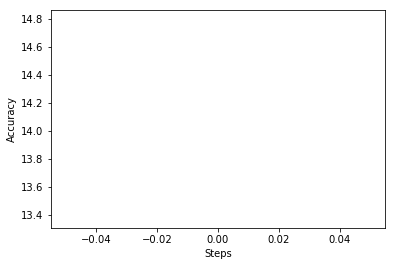

In [17]:
print graphy
plt.plot(graphx,graphy)
plt.ylabel('Accuracy')
plt.xlabel('Steps')
plt.show()

In [18]:
test_accuracy = accuracy.eval(feed_dict={x: testset.images, y: testset.labels, keep_prob: 1.0}, session=sess)
print 'test accuracy %g' % test_accuracy

test accuracy 0.0422535


In [ ]:
saver = tf.train.Saver()
saver.save(sess, "saved models/model"+str(n_classes)+".ckpt")